In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *


In [2]:
CONFIG = dict(
    n_levels=5,
    backbone="tf_efficientnetv2_b0",
    img_size=(128, 128),
    in_chans=1,
    drop_rate=0.05,
    drop_rate_last=0.3,
    drop_path_rate=0.,
    aug_prob=0.7,
    out_dim=3,
    epochs=200,
    batch_size=8,
    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
    seed=2024
)


In [3]:
class CNN_Model_3D(nn.Module):
    def __init__(self, backbone="efficientnet_lite0", in_chans=1, out_classes=5, pretrained=True):
        super(CNN_Model_3D, self).__init__()
        self.out_classes = out_classes

        self.encoder = timm_3d.create_model(
            backbone,
            num_classes=out_classes * CONFIG["out_dim"],
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained,
            in_chans=in_chans,
        ).to(CONFIG["device"])

    def forward(self, x):
        # return self.encoder(x).reshape((-1, self.out_classes, 3))
        return self.encoder(x)

In [4]:
import skorch

from spacecutter.losses import CumulativeLinkLoss
from spacecutter.models import LogisticCumulativeLink
from spacecutter.callbacks import AscensionCallback


class CNN_Model_3D_Multihead(nn.Module):
    def __init__(self, backbone="efficientnet_lite0", in_chans=1, out_classes=5, out_dim=3, pretrained=True):
        super(CNN_Model_3D_Multihead, self).__init__()
        self.out_classes = out_classes

        self.encoder = timm_3d.create_model(
            backbone,
            num_classes=out_classes * CONFIG["out_dim"],
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            # drop_rate_last=CONFIG["drop_rate_last"],
            pretrained=pretrained,
            in_chans=in_chans,
        )
        head_in_dim = self.encoder.classifier.in_features
        self.encoder.classifier = nn.Identity()
        self.heads = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(head_in_dim, 1),
                LogisticCumulativeLink(CONFIG["out_dim"])
            ) for i in range(out_classes)]
        )

        self.ascension_callback = AscensionCallback()

    def forward(self, x):
        feat = self.encoder(x)
        return torch.swapaxes(torch.stack([head(feat) for head in self.heads]), 0, 1)

    def _ascension_callback(self):
        for head in self.heads:
            self.ascension_callback.clip(head[1])


In [22]:
import torch

series_inference_model = torch.load("../models\\tf_efficientnetv2_m_144_3d\\tf_efficientnetv2_m_144_3d_29.pt")
series_inference_model.eval()

CNN_Model_3D(
  (encoder): EfficientNet(
    (conv_stem): Conv3dSame(3, 24, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False)
    (bn1): BatchNormAct3d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn1): BatchNormAct3d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (bn1): BatchNormAct3d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Si

In [6]:
import numpy as np

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

transform = tio.Compose([
        tio.Resize((144, 144, 144), image_interpolation="bspline"),
        tio.RescaleIntensity(out_min_max=(0, 1)),
    ])

(trainloader, valloader, test_loader,
 trainset, valset, testset) = create_subject_level_datasets_and_loaders(TRAINING_DATA,
                                                                        transform_3d_train=transform,
                                                                        transform_3d_val=transform,
                                                                        base_path=os.path.join(
                                                                           DATA_BASEPATH,
                                                                           "train_images"),
                                                                        num_workers=0,
                                                                        split_factor=0.3,
                                                                        batch_size=8)


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [7]:
for i in test_loader:
    print(i)
    break

[tensor([[[[[0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0773, 0.0797, 0.0821,  ..., 0.0749, 0.0749, 0.0749],
           ...,
           [0.0749, 0.0821, 0.0845,  ..., 0.0749, 0.0749, 0.0749],
           [0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749]],

          [[0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0773, 0.0797, 0.0821,  ..., 0.0749, 0.0749, 0.0749],
           ...,
           [0.0749, 0.0821, 0.0845,  ..., 0.0749, 0.0749, 0.0749],
           [0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749]],

          [[0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0749, 0.0749, 0.0749,  ..., 0.0749, 0.0749, 0.0749],
           [0.0773, 0.079

In [23]:
from tqdm import tqdm

inferred = []
target = []

with torch.no_grad():
    for image, label in tqdm(test_loader):
        target.append(label.detach())
        inferred.append(series_inference_model(image.to("cuda")).detach())


100%|██████████| 17/17 [04:38<00:00, 16.35s/it]


In [24]:
import torch.nn as nn

inferred_new = []
target_new = []
for e in inferred:
    for elem in e:
        inferred_new.append(elem.reshape((-1, 25, 3)))
for e in target:
    for elem in e:
        target_new.append([[0 if i != elem_ else 1 for i in range(3)] for elem_ in elem])
        
        
nn.Softmax(dim=2)(inferred_new[1]), target_new[1]

(tensor([[[9.9684e-01, 2.7349e-03, 4.2331e-04],
          [9.4605e-01, 5.1531e-02, 2.4204e-03],
          [4.3672e-01, 5.3884e-01, 2.4443e-02],
          [2.7211e-01, 5.3349e-01, 1.9440e-01],
          [3.2355e-01, 3.6374e-01, 3.1271e-01],
          [9.9617e-01, 2.7058e-03, 1.1208e-03],
          [5.9302e-01, 3.6442e-01, 4.2555e-02],
          [1.0942e-01, 4.3973e-01, 4.5085e-01],
          [7.7992e-02, 3.8675e-01, 5.3526e-01],
          [6.7193e-01, 2.0812e-01, 1.1994e-01],
          [9.9856e-01, 1.1046e-03, 3.3919e-04],
          [9.7203e-01, 2.3759e-02, 4.2122e-03],
          [5.0786e-01, 4.1178e-01, 8.0360e-02],
          [2.1535e-01, 5.3965e-01, 2.4500e-01],
          [4.1881e-01, 3.6189e-01, 2.1930e-01],
          [9.9051e-01, 7.6386e-03, 1.8474e-03],
          [7.5759e-01, 1.9498e-01, 4.7438e-02],
          [1.3852e-01, 4.0240e-01, 4.5909e-01],
          [5.7784e-02, 2.9943e-01, 6.4279e-01],
          [5.7402e-01, 2.2828e-01, 1.9769e-01],
          [9.9473e-01, 4.4643e-03, 8.056

In [25]:
inferred_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred_new]
target_l = [[np.argmax(e_) for e_ in e] for e in target_new]

In [26]:
len(inferred_l[1]), len(target_l[1])

(25, 25)

In [27]:
train_labels = list(trainset.labels.values())
train_labels = [e.reshape(-1, 25, 3)[0] for e in train_labels]
train_labels[0]

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
train_df = pd.DataFrame([np.argmax(e, axis=1) for e in train_labels])
relative_weights = []
for i in range(25):
    curr_gr = train_df.groupby(i).count().values[:,0]
    curr_gr = (sum(curr_gr) - curr_gr) / curr_gr
    relative_weights.append(list(curr_gr))
relative_weights = np.array(relative_weights)
list(relative_weights)

In [ ]:
train_df.groupby(1).count()

In [ ]:
train_df.groupby(1).count()

In [ ]:
train_df.groupby(2).count()

In [ ]:
train_df.groupby(3).count()


In [ ]:
train_df.groupby(4).count()


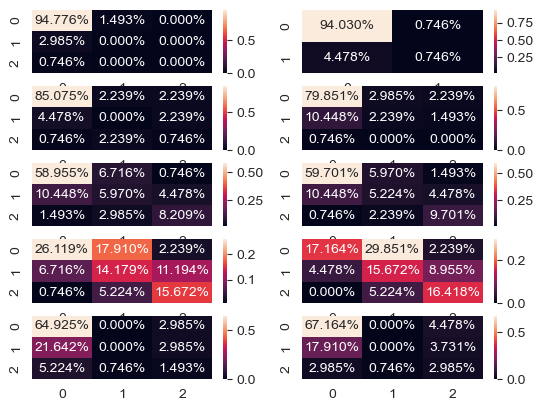

In [28]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from operator import truediv

precisions_l = []
recalls_l = []

precisions_r = []
recalls_r = []

# !TODO: Refactor
fig, ax = plt.subplots(nrows=5, ncols=2)
for i in range(5):
    target_ = [e[i + 5] for e in target_l]
    inferred_ = [e[i + 5] for e in inferred_l]

    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[i][0], annot=True, fmt='.3%')

    true_pos = np.diag(cf_matrix)
    prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
    rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
    
    precisions_l.append(prec)
    recalls_l.append(rec)

    target_ = [e[i + 15] for e in target_l]
    inferred_ = [e[i + 15] for e in inferred_l]

    cf_matrix = confusion_matrix(target_, inferred_)
    sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[i][1], annot=True, fmt='.3%')

    true_pos = np.diag(cf_matrix)
    prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
    rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
    
    precisions_r.append(prec)
    recalls_r.append(rec)

plt.show()


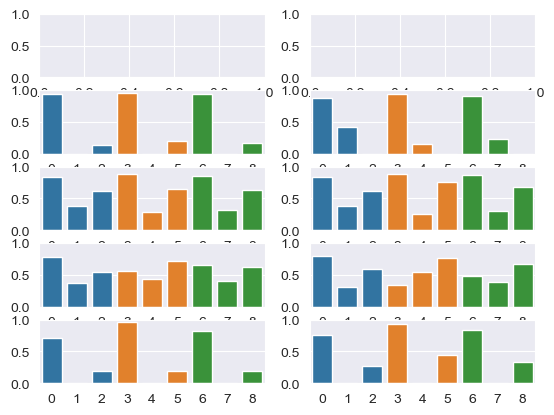

In [29]:
fig, ax = plt.subplots(nrows=5, ncols=2)
plt.set_loglevel('WARNING')
for i in range(1,5):
    ax[i][0].set(ylim=(0, 1))
    sn.barplot(x=range(3), y=precisions_l[i], ax=ax[i][0])
    sn.barplot(x=range(3, 6), y=recalls_l[i], ax=ax[i][0])
    sn.barplot(x=range(6, 9), y=2 / (1 / (np.array(recalls_l[i]) + 1e-7) + 1 / (np.array(precisions_l[i]) + 1e-7)), ax=ax[i][0])

    ax[i][1].set(ylim=(0, 1))
    sn.barplot(x=range(3), y=precisions_r[i], ax=ax[i][1])
    sn.barplot(x=range(3, 6), y=recalls_r[i], ax=ax[i][1])
    sn.barplot(x=range(6, 9), y=2 / (1 / (np.array(recalls_r[i]) + 1e-7) + 1 / (np.array(precisions_r[i]) + 1e-7)), ax=ax[i][1])

plt.show()
